# An In-depth Exploration of US Job Market by analyzing LinkedIn Job Postings using Natural Language Processing Techniques

## Data ingestion and preprocesing
We firstly need to read the webscraped dataset and explore its contents before we begin the analysis.
For a better understanding of one domain we will focus on the jobs regarding the IT industry.

In [118]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from ollama import chat
from pydantic import BaseModel, Field
from typing import List
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [119]:
# Read the dataset
data = pd.read_csv('/Users/juliabarsow/Desktop/thesis/project_code/postings.csv')

In [147]:
# Check how many descriptions are missing as this is the most important column
print("Missing rows of description: ",data['description'].isnull().sum())

# Drop rows with missing descriptions
data = data.dropna(subset=['description'])

Missing rows of description:  7


In [148]:
# List of titles to take into account in our project
# 'Project Manager' was excluded as it contained also non-IT related job postings
titles_to_classify = [
    'Full Stack Engineer',
    'Java Architect',
    'Intern- Business Analytics',
    'Frontend Engineer',
    'Machine Learning Engineer',
    'Junior Project Manager',
    'Azure Data Engineer',
    'Sr. Project Engineer',
    'Junior Business Analyst',
    'Cloud / .NET Developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Computer Scientist',
    'DevOps Engineer',
    'Front end specialist',
    'Project Engineer',
    'Data Architect',
    'Data Analyst',
    'Java architect / Lead Java developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Senior Software Engineer',
    'Web Developer',
    'Software Implementation Program Manager',
    'Test Engineer',
    'Sr Software Engineer',
    'IT QA Engineer II',
    'Sr. Business Analyst/Tester',
    'Senior Developer – React Native',
    'Cloud DevOps Engineer',
    'Senior Analyst, Data & Analytics',
    'Senior Business Analyst',
    'Engineering Project Manager / Project Manager',
    'Java full Stack Engineer',
    'backend Java developer',
    'Data Science Software Engineer',
    'Data Engineer/ETL'
]

# Filter the dataset to include only the specified titles
data = data[data['title'].isin(titles_to_classify)].reset_index(drop=True)

<Axes: title={'center': 'Job Title Distribution'}, xlabel='title'>

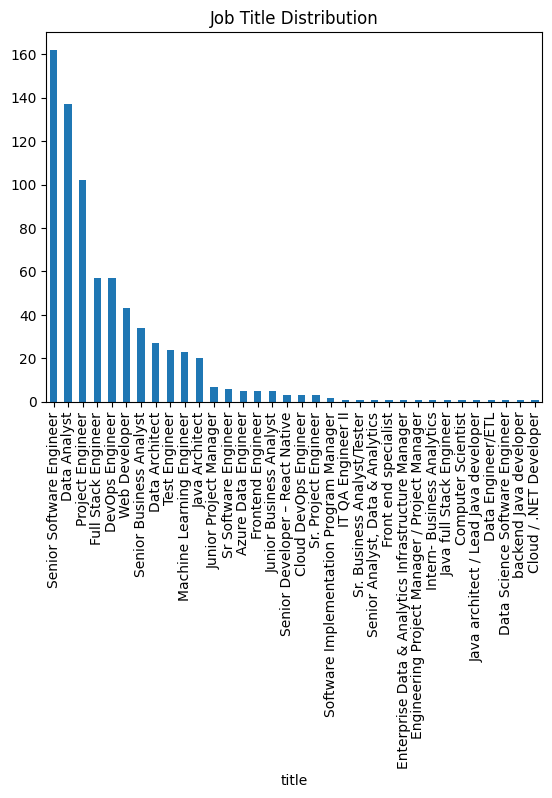

In [6]:
data['title'].value_counts().plot(kind='bar', title='Job Title Distribution')

In [7]:
# Make a copy of dataset for further processing and save only title and description columns
df = data.copy()
df = df[['job_id', 'title', 'description']]

In [8]:
def classify_job_titles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'general job classification' to a DataFrame based on 
    keywords found in the 'title' column.

    The classification logic applies rules in a specific order of precedence
    to handle complex or overlapping job titles.

    Args:
        df: The input pandas DataFrame containing a 'title' column.

    Returns:
        The modified DataFrame with the new 'general job classification' column.
    """
    if 'title' not in df.columns:
        print("Error: DataFrame must contain a 'title' column.")
        return df

    # Convert titles to lowercase for case-insensitive matching
    titles_lower = df['title'].str.lower().fillna('')

    # Use a function to apply classification rules with precedence
    def get_classification(title: str) -> str:
        """Determines the classification based on keywords in order of importance."""

        # 1. Project Management
        # Check for Program Manager or Project Manager/Engineer first
        if 'program manager' in title or 'project manager' in title or 'project engineer' in title:
            return 'Project Management'

        # 2. Data & Analytics (Includes specialized data engineering/ML roles)
        if ('data' in title and ('engineer' in title or 'analyst' in title or 'architect' in title)) or \
           'machine learning' in title or 'analytics' in title or 'etl' in title or 'data science' in title:
            return 'Data & Analytics'

        # 3. Business Analysis
        if 'business analyst' in title:
            return 'Business Analysis'
        
        # 4. Technical Architecture (Catch-all for non-data architects)
        if 'architect' in title:
            return 'Technical Architecture'

        # 5. Software Development / Engineering (The catch-all for core tech roles)
        if 'software engineer' in title or 'developer' in title or 'devops' in title or \
           'full stack' in title or 'web developer' in title or 'frontend' in title or \
           'test engineer' in title or 'qa engineer' in title or 'computer scientist' in title or 'front end' in title:
            return 'Software Development / Engineering'

        # Default classification
        return 'Other/Unclassified'

    # Apply the classification function to the lowercase titles
    df['general job classification'] = titles_lower.apply(get_classification)
    
    return df

In [9]:
df = classify_job_titles(df)

<Axes: title={'center': 'Job Type Distribution'}, xlabel='general job classification'>

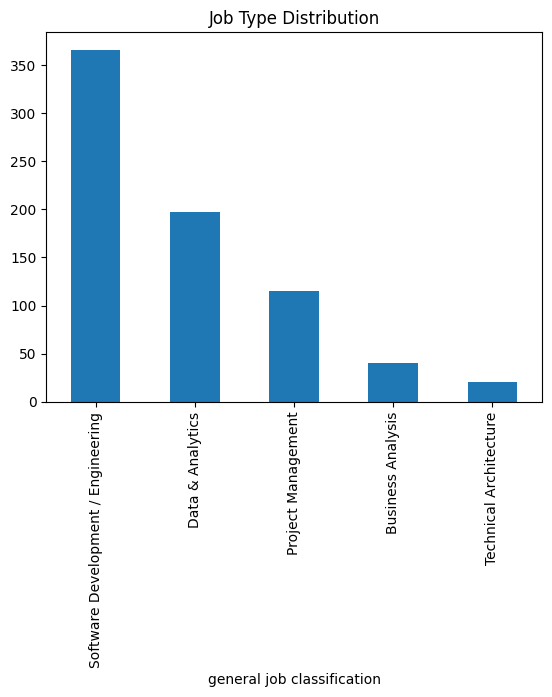

In [11]:
df['general job classification'].value_counts().plot(kind='bar', title='Job Type Distribution')

## Skill Extraction and Clustering

### Objective: Extract required skills from job descriptions and cluster them to identify common skill sets across industries.

Research Questions:

- What are the most in-demand skills across different sectors?

-  How do skill requirements differ by salary range or job title?

-  What are the salary ranges in different sectors and job positions?


### We will use Ollama: https://ollama.com/ for the skill extraction

In [ ]:
# Run these commands in terminal to set up ollama and run the model
!pip install ollama
!python3 -m ollama pull llama3.2
!python3 -m ollama run granite3.2:8b

In [12]:
# Define the desired output structure using Pydantic
# This creates a JSON Schema that Ollama is forced to follow.
class JobRequirements(BaseModel):
    """A structured model to hold the extracted skills and requirements from a job posting."""
    skills: List[str] = Field(
        ..., 
        description="A list of specific, technical, or soft skills required. E.g., 'Python', 'Machine Learning', 'Problem-Solving'."
    )
    requirements: List[str] = Field(
        ..., 
        description="A list of formal requirements, like years of experience, educational degrees, or specific certifications. E.g., 'Bachelor's Degree in Computer Science', '5+ years of experience with Kafka', 'AWS Certified'."
    )

In [13]:
# Define the prompt and configuration for Ollama
def extract_skills_requirements(job_post: str, model_name: str = "llama3.2") -> JobRequirements:
    """
    Sends the job posting to an Ollama model and extracts structured data.
    """
    
    # Generate the JSON schema from the Pydantic model
    schema = JobRequirements.model_json_schema()

    # The system prompt guides the model's behavior
    system_prompt = (
        "You are an expert HR data extraction bot. Your task is to accurately "
        "extract the required skills and formal requirements from the provided job posting. "
        "Do not include any commentary or additional text. "
        "The output MUST conform strictly to the provided JSON schema."
    )
    
    # The user prompt contains the data to be analyzed
    user_prompt = f"Analyze the following job posting and return the extracted data:\n\n---\n{job_post}"
    
    print(f"--- Sending request to Ollama with model: {model_name} ---")

    try:
        response = chat(
            model=model_name,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            # This is the key setting for structured output!
            format=schema,
            # Use temperature 0 for deterministic, reliable extraction
            options={'temperature': 0}
        )
        
        # The model's content is a JSON string conforming to the schema
        json_string = response['message']['content']
        
        # Validate and convert the JSON string back into a Pydantic object
        extracted_data = JobRequirements.model_validate_json(json_string)
        
        return extracted_data

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Ensure Ollama server is running and the model is pulled.")
        return None

In [14]:
# Add extracted skills and formal requirements to the DataFrame
def append_skills_requirements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts skills and formal requirements from each job description in the DataFrame
    and appends them as new columns.

    Args:
        df: The input DataFrame with a 'description' column.

    Returns:
        The modified DataFrame with 'skills' and 'formal_requirements' columns.
    """
    skills_list = []
    requirements_list = []

    for i, job_posting_text in enumerate(df['description']):
        print(f"Processing row {i + 1}/{len(df)}...")
        result = extract_skills_requirements(job_posting_text)
        if result:
            skills_list.append(result.skills)
            requirements_list.append(result.requirements)
        else:
            skills_list.append([])  # Append empty list if extraction fails
            requirements_list.append([])

    # Add the extracted data as new columns
    df['skills'] = skills_list
    df['formal_requirements'] = requirements_list

    return df

In [71]:
df_skills = append_skills_requirements(df)

Processing row 1/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 2/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 3/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 4/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 5/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 6/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 7/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 8/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 9/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 10/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 11/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 12/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 13/739...
--- Sending request to O

In [72]:
df_skills.to_csv('job_postings_with_skills.csv', index=False)

In [15]:
df_skills = pd.read_csv('job_postings_with_skills.csv')

In [19]:
df_skills.head()

,title,description,general job classification,skills,formal_requirements
0,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",Software Development / Engineering,"['full-stack web development', 'JavaScript/Typ...",['3+ years of professional experience in softw...
1,Computer Scientist,Are you passionate about developing cutting-ed...,Software Development / Engineering,"['software development', 'deep space communica...","[""Bachelor's degree in Computer Science or rel..."
2,Front end specialist,Regional law firm looking for a candidate with...,Software Development / Engineering,"['phone sales', 'customer service', 'interpers...","['superior phone sales experience', 'passion f..."
3,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,Data & Analytics,"['data analysis', 'modeling', 'visualization',...","['MBA program with a focus in data analytics',..."
4,Project Engineer,JOB DESCRIPTION:The Project Engineer assists t...,Project Management,"['Construction/Civil Engineering', 'Architectu...","[""Bachelor's degree in Construction/Civil Engi..."


### Test the result of llama prediction - how valuable is this classification how to check it? can we do sth automated instead of manual?
Because we have no labeled dataset with skills we will use manual validation to check if the skills exctracted are correct

## Clustering skills

### In terminal/command line - Install and load the largest available SpaCy model:

python -m spacy download en_core_web_lg 

Prepare the Unique Skills List (Low-Effort Cleaning)
Filter your entire dataset's extracted skills to create a single list of unique terms, which is the input for vectorization.

Using Pandas and basic string methods to clean and deduplicate the skills from df['extracted_skills'] column.

In [18]:
# Explode the list column into individual rows, keeping the index.
# Convert all skills to lowercase for standardization.
# Drop missing/empty values (if any).
unique_skills_series = df_skills['skills'].explode().str.lower().dropna().drop_duplicates()
unique_skills_list = unique_skills_series.tolist()

# Filter out very rare, noisy skills
# Only keep skills that appear in at least 3 job postings (adjust N as needed)
skill_counts = df_skills['skills'].explode().str.lower().value_counts()
frequent_skills = skill_counts[skill_counts >= 3].index.tolist()
unique_skills_list = [skill for skill in unique_skills_list if skill in frequent_skills]

print(f"Number of skills to cluster: {len(unique_skills_list)}")

Number of skills to cluster: 7


In [21]:
# this is another version for reading form the csv instead of passing from previous cells
import ast

# If skills were saved as strings like "['a','b']", convert back to lists
def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.strip().startswith('['):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return []

df_skills['skills'] = df_skills['skills'].apply(ensure_list)

# Normalize tokens: strip, lower, remove empty strings
def normalize_list(lst):
    return [s.strip().lower() for s in lst if isinstance(s, str) and s.strip()]

df_skills['skills'] = df_skills['skills'].apply(normalize_list)

# Count unique skills and frequency across job postings (count each job once per skill)
exploded = df_skills[['skills']].explode('skills').dropna()
# Count how many distinct job rows contain each skill (use index as job identifier)
skill_counts = exploded.reset_index().drop_duplicates(subset=['index','skills']).groupby('skills').size().sort_values(ascending=False)

# Choose threshold (>=3 postings here)
freq_threshold = 3
frequent_skills = skill_counts[skill_counts >= freq_threshold].index.tolist()

unique_skills_list = frequent_skills[:]  # skills to cluster
print("unique before filter:", exploded['skills'].drop_duplicates().shape[0])
print("unique after freq filter (>= {}): {}".format(freq_threshold, len(unique_skills_list)))
print("Top skills:\n", skill_counts.head(20))
# ...existing code...

unique before filter: 3256
unique after freq filter (>= 3): 433
Top skills:
 skills
python                209
sql                   164
javascript            150
c#                    106
html                  104
c++                    95
java                   79
project management     78
react                  63
typescript             55
aws                    54
data analysis          54
kubernetes             49
angular                44
docker                 41
git                    41
communication          37
css                    35
excel                  33
node.js                28
dtype: int64


In [23]:
unique_skills_list[:10]  # Display the first 10 unique skills

['python',
 'sql',
 'javascript',
 'c#',
 'html',
 'c++',
 'java',
 'project management',
 'react',
 'typescript']

# First clustering approach - SpaCy Vector embedding

Fast Vector Generation (Low Computational Cost)
This is the fastest step. SpaCy simply looks up the pre-computed vector for each skill.

Generate a vector for every unique skill.

In [24]:
# Load the model with vectors
nlp = spacy.load("en_core_web_lg")

In [25]:
# Use a list comprehension to get the vector for each skill
# .vector provides the 300-dimensional vector from the en_core_web_lg model
skill_vectors = np.array([nlp(skill).vector for skill in unique_skills_list])

# Scale the skill vectors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_skill_vectors = scaler.fit_transform(skill_vectors)

Simple KMeans Clustering
KMeans is computationally fast and easy to interpret.

Apply KMeans to the skill_vectors. Start with a reasonable number of clusters, then check the optimal number.

In [26]:
def find_elbow_point(k_values, inertia_values):
    """
    Identifies the elbow point in the inertia curve using the maximum second derivative method.

    Args:
        k_values: List of K values.
        inertia_values: Corresponding inertia values for each K.

    Returns:
        int or None: The K value at the elbow point.
    """
    # Calculate the second derivative of inertia values
    second_derivative = np.diff(inertia_values, n=2)

    # Find peaks in the second derivative (elbow points)
    peaks, _ = find_peaks(-second_derivative)  # Negative because we want maxima in the original curve

    if len(peaks) > 0:
        elbow_k = k_values[peaks[0] + 1]  # +1 to account for the diff reducing the array size
        return elbow_k
    else:
        return None

In [27]:
def plot_elbow_curve(vectors, k_range=range(2, 25)):
    """
    Plots the Elbow Curve for K-Means clustering and identifies the optimal number of clusters.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        k_range (range): The range of K values to test.

    Returns:
        int or None: The optimal number of clusters (K) if detected, otherwise None.
    """
    inertia = []

    # Calculate inertia for each K
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range[::2])  # Show every second tick mark for clarity
    plt.grid(True)

    elbow_k = find_elbow_point(list(k_range), inertia)
    if elbow_k:
        print(f"Elbow point detected at K = {elbow_k}")
        plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at K={elbow_k}')
        plt.legend()
    else:
        print("No clear elbow point detected.")
    plt.show()

    return elbow_k

Elbow point detected at K = 5


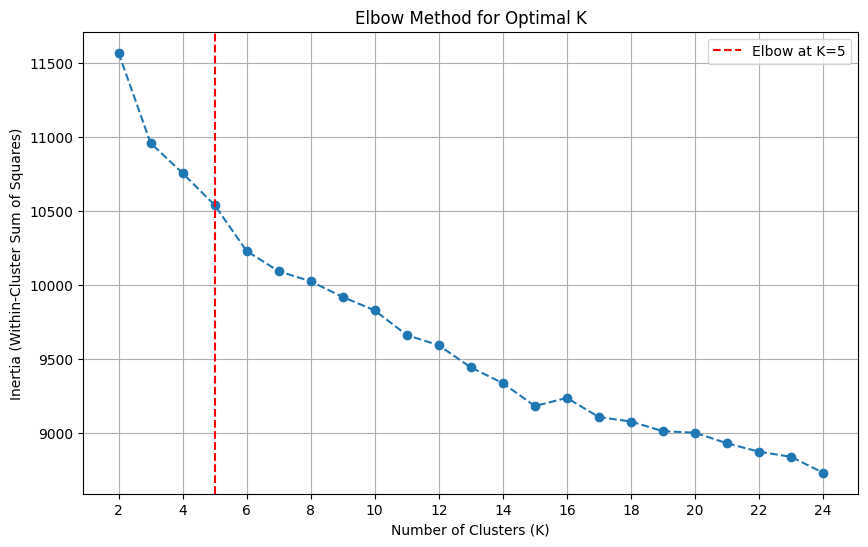

Optimal number of clusters: 5


In [28]:
# elbow plot for optimal number of clusters
optimal_k = plot_elbow_curve(skill_vectors)
print(f"Optimal number of clusters: {optimal_k}")

In [29]:
def plot_silhouette_scores(skill_vectors, k_range=range(2, 25)):
    """
    Plots the Silhouette Score for K-Means clustering to help determine the optimal number of clusters.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        k_range (range): The range of K values to test.

    Returns:
        dict: A dictionary with K values as keys and their corresponding Silhouette Scores as values.
    """
    silhouette_scores = {}

    # Calculate Silhouette Score for each K
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(skill_vectors)
        labels = kmeans.predict(skill_vectors)
        silhouette_scores[k] = silhouette_score(skill_vectors, labels)

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bx-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title('Silhouette Score Method for Optimal K')
    plt.grid(True)
    plt.xticks(list(k_range)[::2])  # Show every second tick mark for clarity
    plt.show()

    return silhouette_scores

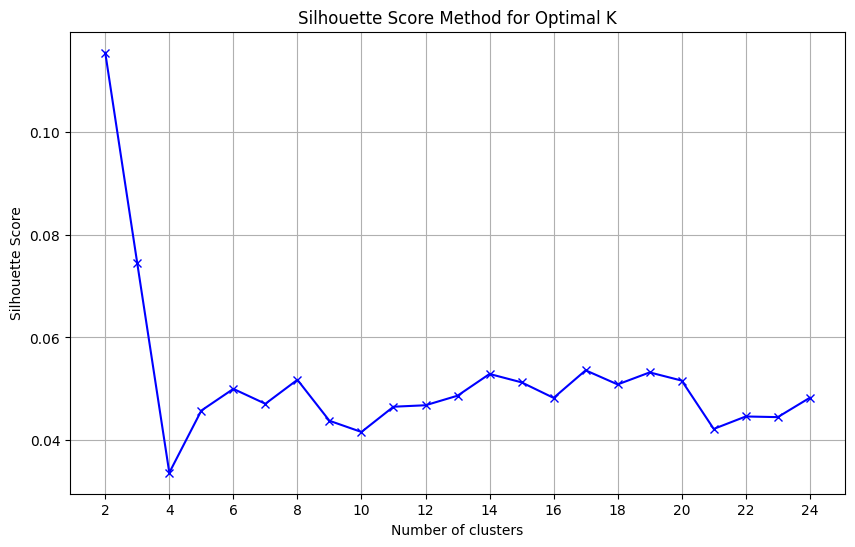

{2: 0.11549387872219086, 3: 0.07443517446517944, 4: 0.033647388219833374, 5: 0.04576040804386139, 6: 0.04998385161161423, 7: 0.04708258807659149, 8: 0.05175802484154701, 9: 0.04377167671918869, 10: 0.04158655181527138, 11: 0.046509310603141785, 12: 0.04679356887936592, 13: 0.048656005412340164, 14: 0.05289212241768837, 15: 0.05125709995627403, 16: 0.048230256885290146, 17: 0.05360328033566475, 18: 0.05085266754031181, 19: 0.05319554731249809, 20: 0.05160036310553551, 21: 0.04218265414237976, 22: 0.04460889846086502, 23: 0.04448140412569046, 24: 0.048254597932100296}


In [30]:
# Plot silhouette scores to help determine optimal K for vectors
silhouette_scores = plot_silhouette_scores(skill_vectors)
print(silhouette_scores)

In [31]:
def perform_kmeans_clustering(skill_vectors, unique_skills_list, K, random_state=42):
    """
    Performs K-Means clustering on the given skill vectors and calculates metrics.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        unique_skills_list (list): List of unique skills corresponding to the vectors.
        K (int): The number of clusters.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        tuple: A tuple containing:
            - cluster_labels (ndarray): Cluster labels for each skill vector.
            - inertia_value (float): Inertia value for the chosen K.
            - sc_score (float): Silhouette score for the chosen K.
            - skill_to_cluster_id (pd.Series): Mapping of skills to their cluster IDs.
    """
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=K, random_state=random_state, init='k-means++', n_init='auto')
    cluster_labels = kmeans.fit_predict(skill_vectors)

    # Calculate inertia and silhouette score
    inertia_value = kmeans.inertia_
    sc_score = silhouette_score(skill_vectors, cluster_labels)

    # Mapping skill to its cluster ID
    skill_to_cluster_id = pd.Series(cluster_labels, index=unique_skills_list)

    # Print metrics
    print(f"Inertia for K={K}: {inertia_value}")
    print(f"Silhouette Score for K={K}: {sc_score}")

    return cluster_labels, inertia_value, sc_score, skill_to_cluster_id

In [35]:
# Perform clustering and get results
cluster_labels, inertia_value, sc_score, skill_to_cluster_id = perform_kmeans_clustering(skill_vectors, unique_skills_list, K=7)

Inertia for K=7: 10094.224609375
Silhouette Score for K=7: 0.04708258807659149


In [36]:
def print_clusters_and_skills(skill_to_cluster_id, K):
    """
    Prints the clusters and their associated skills.

    Args:
        skill_to_cluster_id (pd.Series): A mapping of skills to their cluster IDs.
        K (int): The number of clusters.

    Returns:
        None
    """
    for cluster_id in range(K):
        print(f"Cluster {cluster_id}:")
        cluster_skills = [skill for skill, cluster in skill_to_cluster_id.items() if cluster == cluster_id]
        print(", ".join(cluster_skills))
        print("-" * 50)

In [37]:
print_clusters_and_skills(skill_to_cluster_id, K=7)

Cluster 0:
communication, machine learning, analytical skills, communication skills, problem solving, leadership, organizational skills, technical writing, interpersonal skills, teamwork, deep learning, mathematics, critical thinking, verbal communication, written communication, training, technical leadership, problem-solving skills, team leadership
--------------------------------------------------
Cluster 1:
aws, node.js, postgresql, devops, mongodb, kafka, jira, scala, azure devops, css3, nodejs, rdbms, powershell, j2ee, ec2, etl, django, golang, hadoop, json, github, apis, redis, rabbitmq, nosql databases, splunk, elasticsearch, bitbucket, nosql, mvc, maven, informatica, nginx, jdbc, ssis, junit, jpa, gradle, arima, soa, ssrs, yaml, salesforce, saml, sdlc, scss, oauth, teradata
--------------------------------------------------
Cluster 2:
c#, react, angular, spring boot, power bi, problem-solving, ci/cd pipelines, snowflake, r, ci/cd, microservices architecture, bash, spark, go, sp

In [38]:
# Map each skill to its cluster label
def map_skills_to_clusters(skills_list):
    return [skill_to_cluster_id.get(skill) for skill in skills_list if skill in skill_to_cluster_id]

In [39]:
df_clustered_spacy = df_skills.copy()
df_clustered_spacy['skill_cluster_ids'] = df_clustered_spacy['skills'].apply(map_skills_to_clusters)

In [40]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_spacy.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------

In [41]:
def plot_cluster_heatmap(df_clustered, figsize=(12, 8), cmap="YlGnBu"):
    """
    Plots a heatmap showing the frequency of cluster IDs in each general job classification.

    Args:
        df_clustered (pd.DataFrame): The DataFrame containing 'general job classification' and 'skill_cluster_ids'.
        figsize (tuple): The size of the heatmap figure (default is (12, 8)).
        cmap (str): The colormap for the heatmap (default is "YlGnBu").

    Returns:
        None
    """
    # Count the frequency of each cluster ID in each general job classification
    cluster_frequency = df_clustered.explode('skill_cluster_ids') \
                                     .groupby(['general job classification', 'skill_cluster_ids']) \
                                     .size() \
                                     .unstack(fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cluster_frequency, annot=False, cmap=cmap, cbar=True, linewidths=0.5)
    plt.title("Frequency of Cluster IDs in General Job Classifications", fontsize=14)
    plt.xlabel("Cluster ID", fontsize=12)
    plt.ylabel("General Job Classification", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

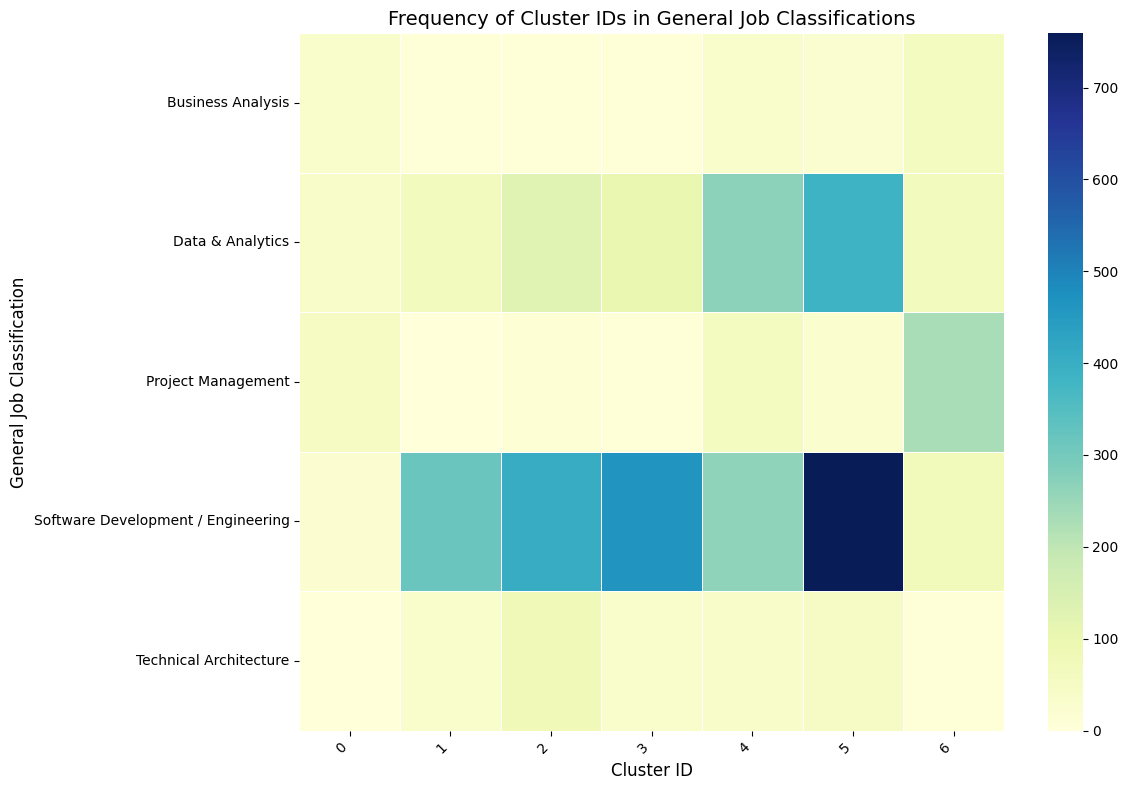

In [42]:
plot_cluster_heatmap(df_clustered_spacy)

In [43]:
# Reduce the 300-dimensional vectors to 2 dimensions
pca = PCA(n_components=2, random_state=42)
skill_vectors_2d = pca.fit_transform(skill_vectors)

# Create a DataFrame for easy plotting
pca_df = pd.DataFrame(skill_vectors_2d, columns=['PC1', 'PC2'])
# Add the cluster labels to the DataFrame
pca_df['Cluster'] = cluster_labels

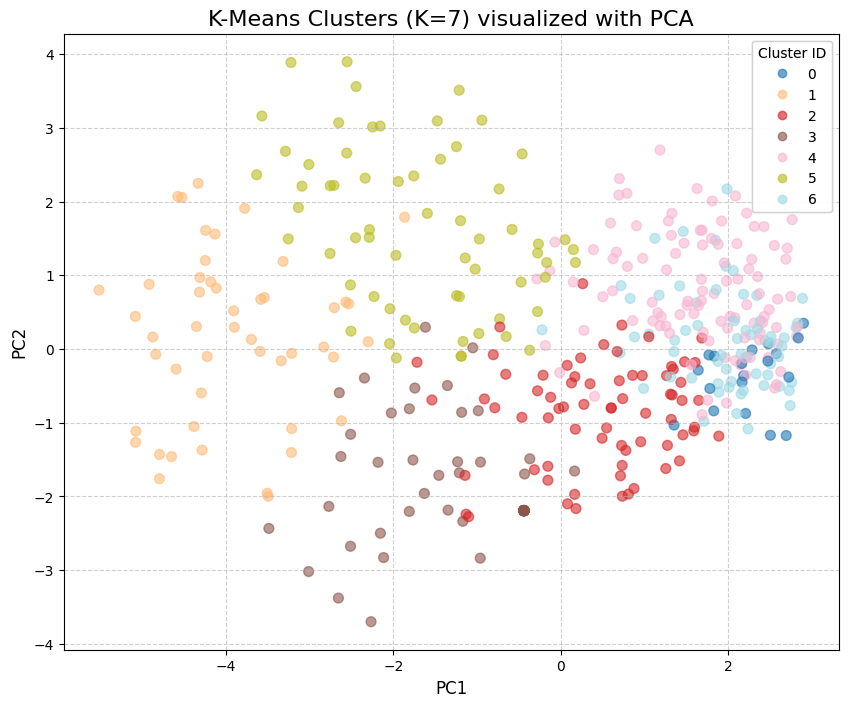

In [45]:
# Assuming you used PCA and the DataFrame is called pca_df
K=7
df_to_plot = pca_df # or tsne_df

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_to_plot.iloc[:, 0], # x-axis: PC1 or tSNE-1
    df_to_plot.iloc[:, 1], # y-axis: PC2 or tSNE-2
    c=df_to_plot['Cluster'], # Color points by cluster label
    cmap='tab20', # Choose a color map with many distinct colors (K=14)
    s=50, # Marker size
    alpha=0.6 # Transparency
)

# Add title and labels based on the reduction method used
plt.title(f'K-Means Clusters (K={K}) visualized with PCA', fontsize=16)
plt.xlabel(df_to_plot.columns[0], fontsize=12)
plt.ylabel(df_to_plot.columns[1], fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Cluster ID",
                    loc="lower right",
                    bbox_to_anchor=(1.25, 0))
plt.gca().add_artist(legend1)
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="upper right")
plt.gca().add_artist(legend1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Second clustering approach - TF-IDF Vectorization

In [154]:
# Use the already prepared unique_skills_list
print(f"Number of unique skills to vectorize: {len(unique_skills_list)}")

# Vectorize the skills using TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)  # Adjust min_df/max_df as needed
tfidf_matrix = vectorizer.fit_transform(unique_skills_list).toarray()


Number of unique skills to vectorize: 433


Elbow point detected at K = 4


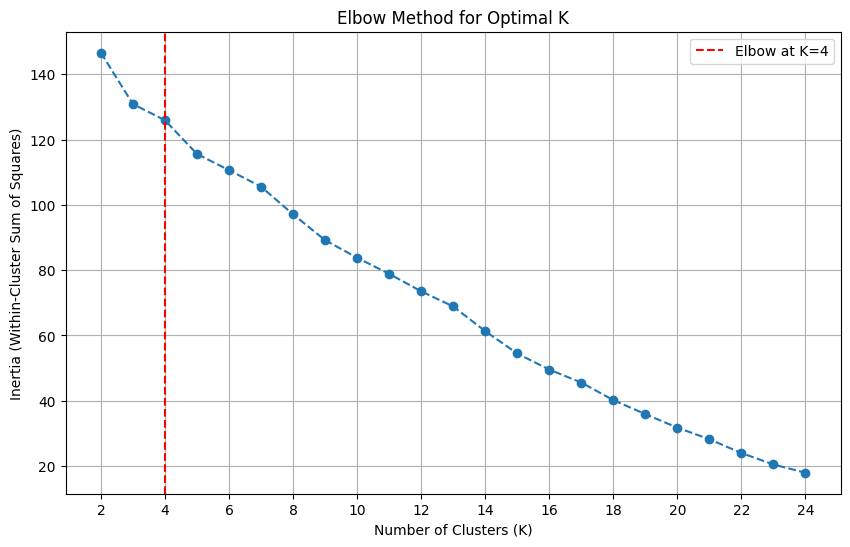

Optimal number of clusters (TF-IDF): 4


In [155]:
# elbow plot for optimal number of clusters
optimal_k_tfidf = plot_elbow_curve(tfidf_matrix)
print(f"Optimal number of clusters (TF-IDF): {optimal_k_tfidf}")

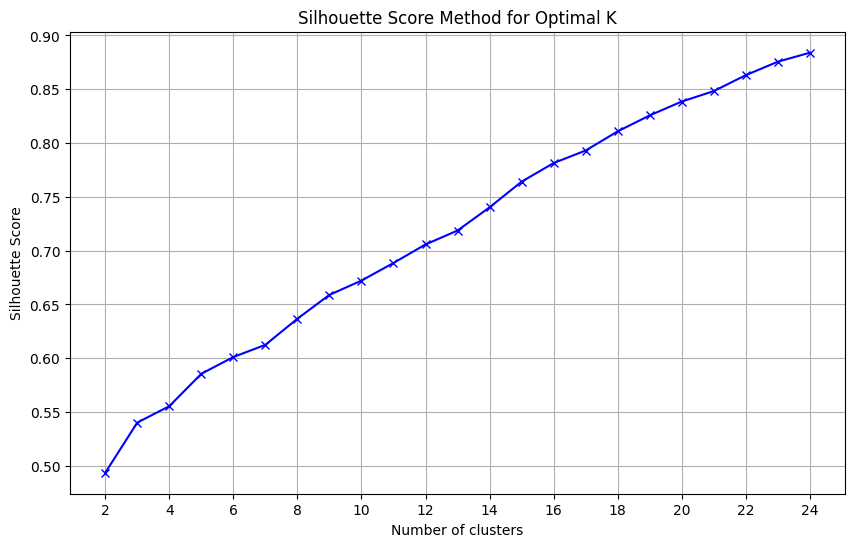

{2: 0.4936820117867747, 3: 0.5402559401641694, 4: 0.5555182819274227, 5: 0.5856143636105984, 6: 0.6011813545713308, 7: 0.6125081670823518, 8: 0.6367859461527394, 9: 0.6589301664766822, 10: 0.6722032703792158, 11: 0.6885594685568854, 12: 0.7057865887609776, 13: 0.7187145632667725, 14: 0.7402657140781899, 15: 0.7641063344839517, 16: 0.7814158424930747, 17: 0.7930607008543898, 18: 0.8108418725521606, 19: 0.8256872254882401, 20: 0.8385676511628631, 21: 0.8482633225758545, 22: 0.8630723283171624, 23: 0.8755753961283689, 24: 0.8839421216979653}


In [156]:
# silhouette plot for optimal number of clusters
silhouette_scores_tfidf = plot_silhouette_scores(tfidf_matrix)
print(silhouette_scores_tfidf)

In [157]:
# perform clustering and get results
cluster_labels_tfidf, inertia_value, sc_score, skill_to_cluster_id = perform_kmeans_clustering(tfidf_matrix, unique_skills_list, K=8)

Inertia for K=8: 97.10443824986098
Silhouette Score for K=8: 0.6367859461527394


In [158]:
print_clusters_and_skills(skill_to_cluster_id, K=7)

Cluster 0:
analytical skills, communication skills, organizational skills, interpersonal skills, problem-solving skills
--------------------------------------------------
Cluster 1:
data analysis, data visualization, data modeling, data warehousing, data analytics, data governance, big data, data structures, data architecture, data mining, data engineering, data acquisitions systems, big data technologies, data manipulation, azure data factory, data security, data pipelines, data integration, data scientist, data mapping, data visualization tools, data preprocessing, data quality
--------------------------------------------------
Cluster 2:
python, javascript, c#, html, c++, java, react, typescript, aws, kubernetes, angular, docker, git, communication, css, excel, postgresql, terraform, devops, software development, tableau, azure, power bi, mysql, jenkins, problem-solving, machine learning, scheduling, linux, engineering, design patterns, business analysis, mongodb, kafka, ci/cd pipel

In [159]:
df_clustered_tfidf = df_skills.copy()
df_clustered_tfidf['skill_cluster_ids'] = df_clustered_tfidf['skills'].apply(map_skills_to_clusters)

In [160]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_tfidf.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(5)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(7)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
--------------------------------------------------


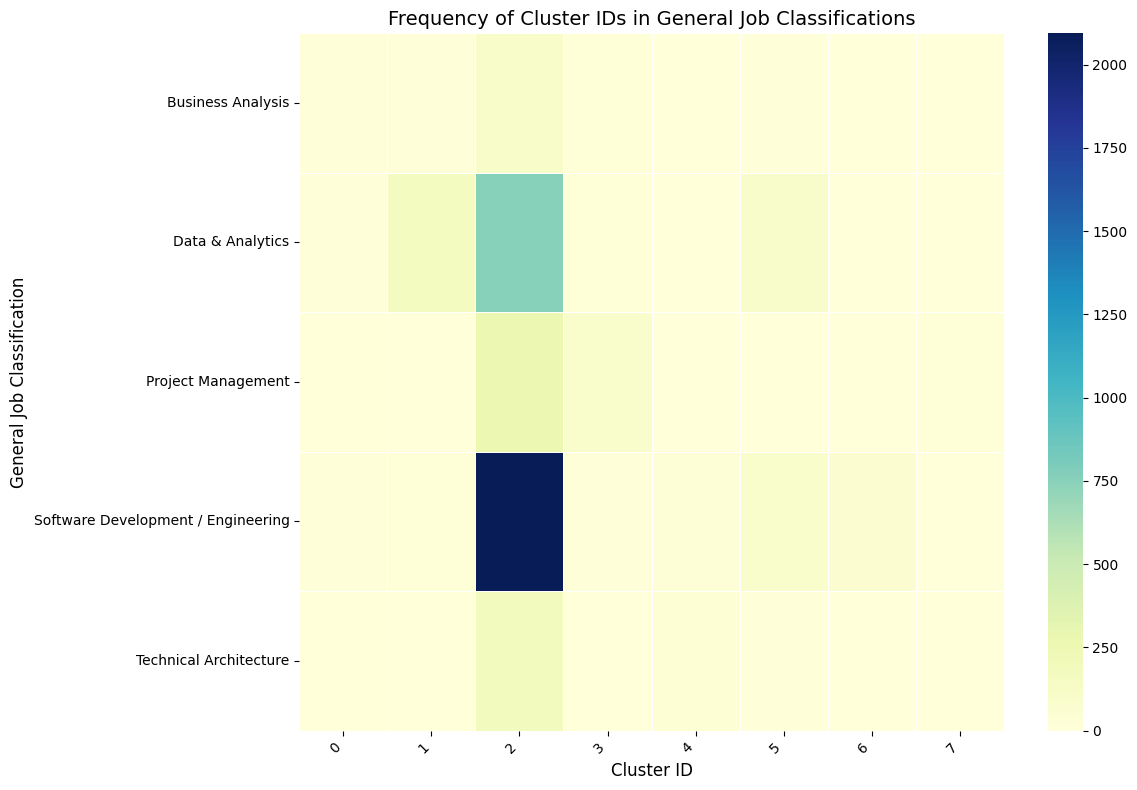

In [91]:
plot_cluster_heatmap(df_clustered_tfidf)

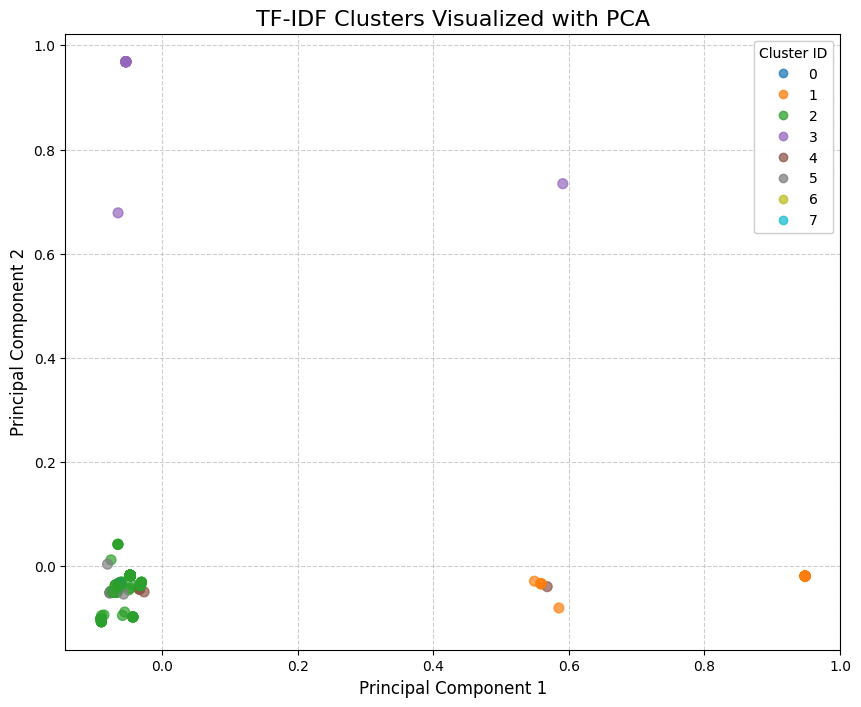

In [92]:
# Step 1: Dimensionality Reduction using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_vectors_2d = pca.fit_transform(tfidf_matrix)

# Step 2: Create a DataFrame for easy plotting
pca_df = pd.DataFrame(tfidf_vectors_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels_tfidf  # Add cluster labels

# Step 3: Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=pca_df['Cluster'], 
    cmap='tab10',  # Use a colormap with distinct colors
    s=50, 
    alpha=0.7
)

# Add title and labels
plt.title('TF-IDF Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="upper right")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Starting t-SNE reduction. This may take a moment...
t-SNE reduction complete.


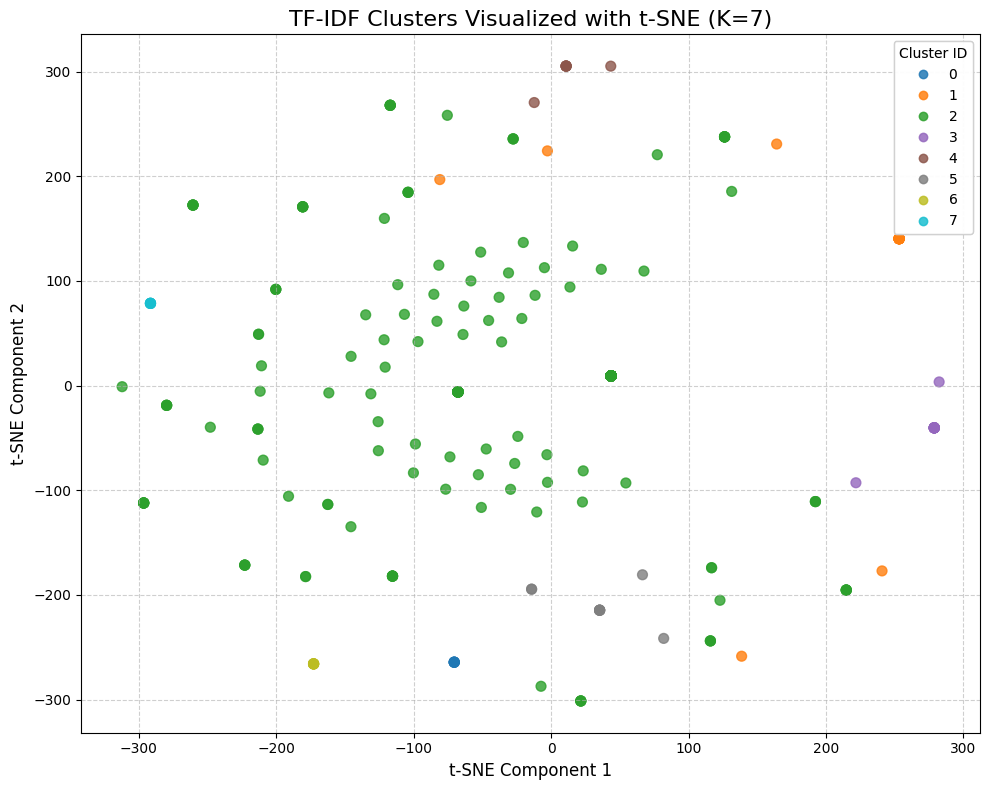


Visualization complete. The t-SNE plot should show clearer separation between the 8 clusters if the Silhouette Score was accurate.


In [94]:
print("\nStarting t-SNE reduction. This may take a moment...")

tsne = TSNE(
    n_components=2,
    perplexity=30,  # Common starting value
    # n_iter=5000,    # High iterations for better convergence
    random_state=42,
    learning_rate='auto', # Recommended for newer versions
    init='pca'      # Initialize with PCA for faster results
)

# Perform the reduction on the high-dimensional TF-IDF data
tfidf_vectors_2d_tsne = tsne.fit_transform(tfidf_matrix)
print("t-SNE reduction complete.")

# --- VISUALIZATION ---

# Step 1: Create a DataFrame for easy plotting
tsne_df = pd.DataFrame(tfidf_vectors_2d_tsne, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = cluster_labels_tfidf  # Add your cluster labels

# Step 2: Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_df['TSNE_1'],
    tsne_df['TSNE_2'],
    c=tsne_df['Cluster'],
    cmap='tab10',  # Use a colormap with distinct colors for the 7 clusters
    s=50,
    alpha=0.8
)

# Add title and labels
plt.title('TF-IDF Clusters Visualized with t-SNE (K=7)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="best")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nVisualization complete. The t-SNE plot should show clearer separation between the 8 clusters if the Silhouette Score was accurate.")


## GloVe embedding

In [56]:
# Load GloVe embeddings
embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100
embedding_dim = 100

# Define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    """
    Converts a sentence to a fixed-size vector using GloVe embeddings.

    Args:
        sentence (str): The input sentence.

    Returns:
        np.ndarray: A flattened vector representation of the sentence.
    """
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:  # Check if the word exists in GloVe vocabulary
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

# Apply the sentence embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['encode_glove'] = unique_skills_df['skill'].apply(sentence_embedding)

# Stack the embeddings into a matrix for clustering
X_glove = np.vstack(unique_skills_df['encode_glove'])

print(f"Shape of GloVe embeddings matrix: {X_glove.shape}")

Shape of GloVe embeddings matrix: (433, 10000)


Elbow point detected at K = 5


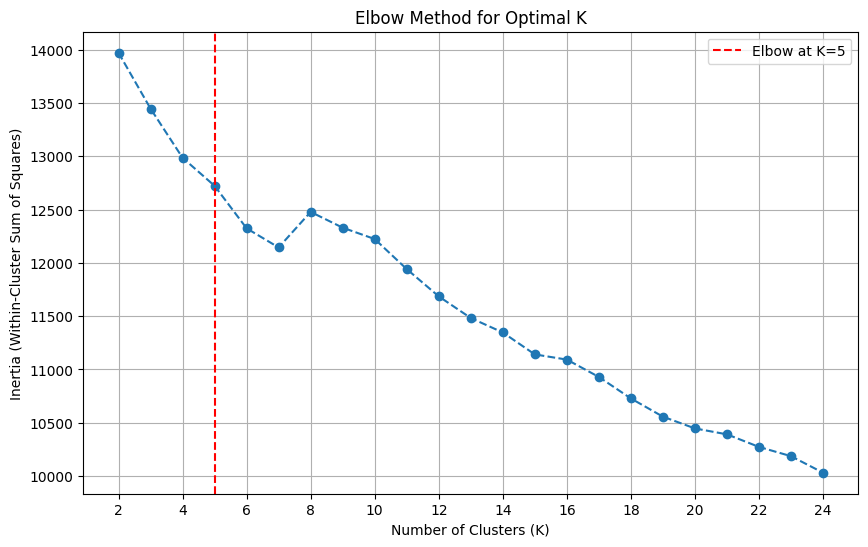

5

In [57]:
plot_elbow_curve(X_glove)

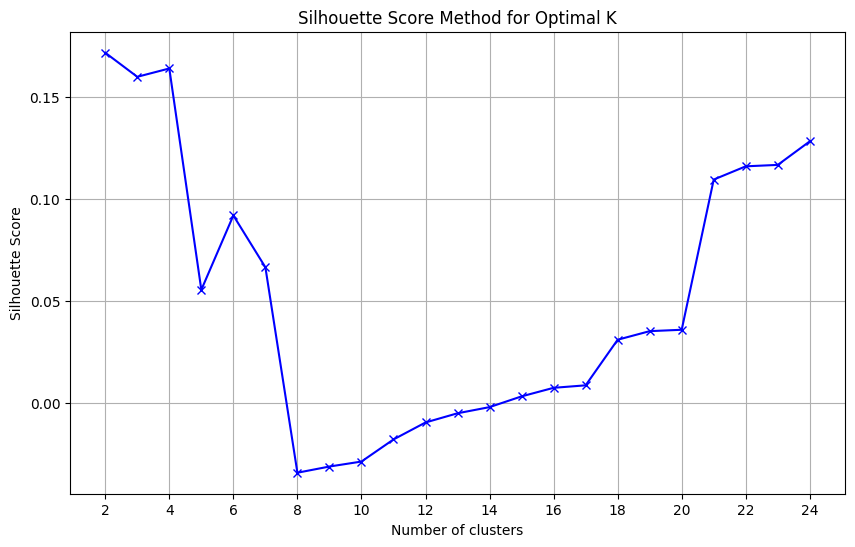

{2: 0.1717169668675121,
 3: 0.15989240401514423,
 4: 0.16398863167975775,
 5: 0.05533409346217516,
 6: 0.0918357236629317,
 7: 0.06641475612921958,
 8: -0.03443926190048926,
 9: -0.03140271873807119,
 10: -0.02895754213334458,
 11: -0.0181115027183825,
 12: -0.009776662964017588,
 13: -0.005260721357711755,
 14: -0.0022373482533921516,
 15: 0.0030364206637974274,
 16: 0.007238790237536568,
 17: 0.008455014843274024,
 18: 0.03083676376303304,
 19: 0.035048496808715135,
 20: 0.03573153316899638,
 21: 0.10945641738915253,
 22: 0.1159569276283299,
 23: 0.11665799037386096,
 24: 0.12822462249857622}

In [58]:
plot_silhouette_scores(X_glove)

In [59]:
# Perform clustering and get results
cluster_labels_glove, inertia_value, sc_score, skill_to_cluster_id = perform_kmeans_clustering(X_glove, unique_skills_list, K=4)

Inertia for K=4: 12985.98165449492
Silhouette Score for K=4: 0.16398863167975775


In [60]:
print_clusters_and_skills(skill_to_cluster_id, K=4)

Cluster 0:
machine learning, analytical skills, sql server, relational databases, microservices architecture, cloud computing, cloud technologies, statistical analysis, distributed systems, mechanical engineering, continuous integration, python programming, communication skills, organizational skills, oops concepts, microservice architecture, aws services, interpersonal skills, no-sql databases, nosql databases, agile methodologies, bdd testing, restful web services, pneumatic test equipment, cloud platforms, ms office, measuring systems, hydraulic test equipment, object-oriented design, mechanical testing, labview software, object-oriented programming, azure data factory, agile environment, api design, front-end development, excel functions, etl processes, r programming, verbal communication, electrical engineering, entity framework, backend development, automation tools, .net framework, neural networks, api development, configuration management, submittal process, elastic search, rel

In [61]:
df_clustered_glove = df_skills.copy()
df_clustered_glove['skill_cluster_ids'] = df_clustered_glove['skills'].apply(map_skills_to_clusters)

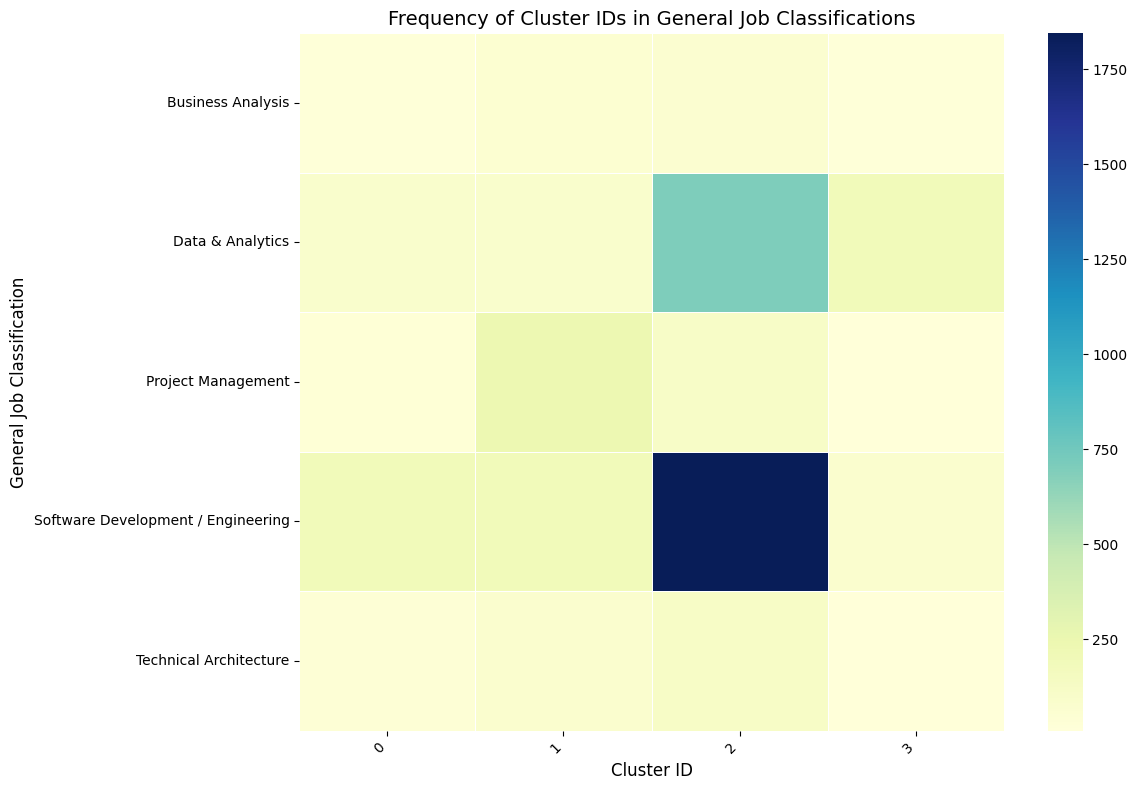

In [62]:
plot_cluster_heatmap(df_clustered_glove)

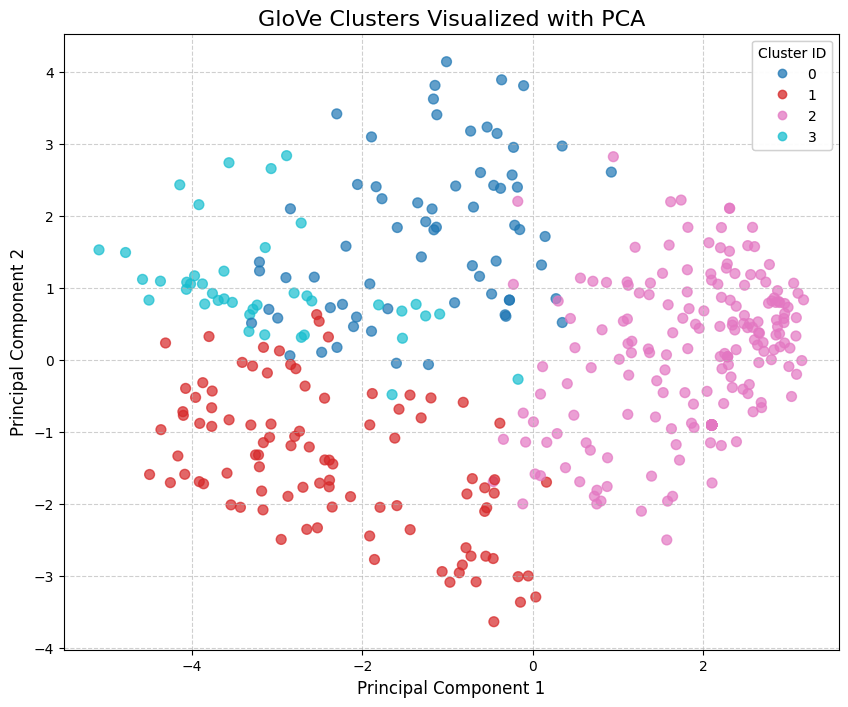

In [63]:
# Step 1: Dimensionality Reduction using PCA
pca = PCA(n_components=2, random_state=42)
glove_vectors_2d = pca.fit_transform(X_glove)

# Step 2: Create a DataFrame for easy plotting
pca_df = pd.DataFrame(glove_vectors_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels_glove  # Add cluster labels

# Step 3: Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=pca_df['Cluster'], 
    cmap='tab10',  # Use a colormap with distinct colors
    s=50, 
    alpha=0.7
)

# Add title and labels
plt.title('GloVe Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="upper right")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## BERT embedding

In [64]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to create BERT embeddings for a given skill
def bert_embedding(skill):
    """
    Converts a skill (sentence) into a BERT embedding.

    Args:
        skill (str): The input skill.

    Returns:
        np.ndarray: A vector representation of the skill.
    """
    # Tokenize the skill and convert to input IDs
    inputs = tokenizer(skill, return_tensors='pt', padding=True, truncation=True, max_length=50)
    
    # Get the BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
    
    return cls_embedding

# Apply the BERT embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['bert_embedding'] = unique_skills_df['skill'].apply(bert_embedding)

# Stack the embeddings into a matrix for clustering
X_bert = np.vstack(unique_skills_df['bert_embedding'])

print(f"Shape of BERT embeddings matrix: {X_bert.shape}")

Shape of BERT embeddings matrix: (433, 768)


Elbow point detected at K = 4


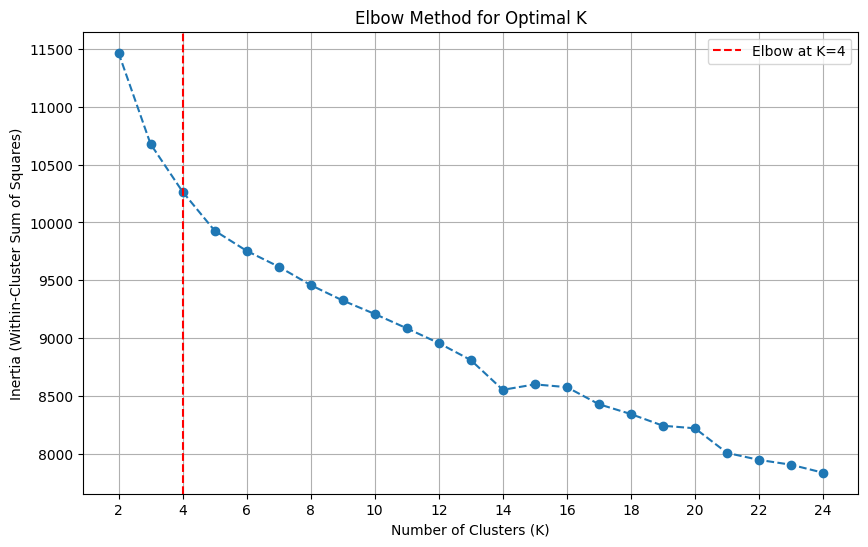

4

In [65]:
plot_elbow_curve(X_bert)

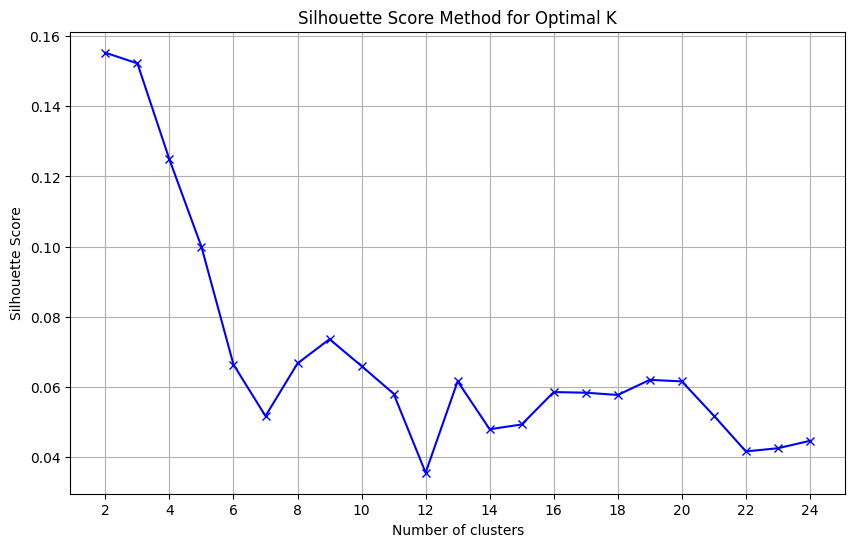

{2: 0.1552913337945938,
 3: 0.15225714445114136,
 4: 0.12485602498054504,
 5: 0.09995757788419724,
 6: 0.06636997312307358,
 7: 0.05168241634964943,
 8: 0.06670761853456497,
 9: 0.07361054420471191,
 10: 0.06594269722700119,
 11: 0.05806891620159149,
 12: 0.03552505373954773,
 13: 0.061594948172569275,
 14: 0.047924287617206573,
 15: 0.04928506538271904,
 16: 0.058523062616586685,
 17: 0.05834605172276497,
 18: 0.057694487273693085,
 19: 0.06200765445828438,
 20: 0.06157240644097328,
 21: 0.05179912969470024,
 22: 0.04160195589065552,
 23: 0.04250917211174965,
 24: 0.044619809836149216}

In [66]:
plot_silhouette_scores(X_bert)

In [69]:
# Perform clustering and get results
cluster_labels_bert, inertia_value, sc_score, skill_to_cluster_id = perform_kmeans_clustering(X_bert, unique_skills_list, K=5)

Inertia for K=5: 9929.158203125
Silhouette Score for K=5: 0.09995757788419724


In [70]:
print_clusters_and_skills(skill_to_cluster_id, K=5)

Cluster 0:
project management, software development, problem-solving, machine learning, data visualization, construction management, engineering, data modeling, business analysis, ci/cd pipelines, relational databases, database management, microservices architecture, cloud computing, statistical analysis, data analytics, rdbms, database design, software engineering, civil engineering, mechanical engineering, business intelligence, project engineering, python programming, performance analysis, microservice architecture, aws services, data mining, data engineering, agile methodologies, time management, pneumatic test equipment, database administration, transducers, construction supervision, post-test damage characterization, data acquisitions systems, big data technologies, test engineering, 3d parametric design software, object-oriented design, job cost accounting, chemical engineering, object-oriented programming, front-end development, data security, data pipelines, electrical enginee

In [71]:
df_clustered_bert = df_skills.copy()
df_clustered_bert['skill_cluster_ids'] = df_clustered_bert['skills'].apply(map_skills_to_clusters)

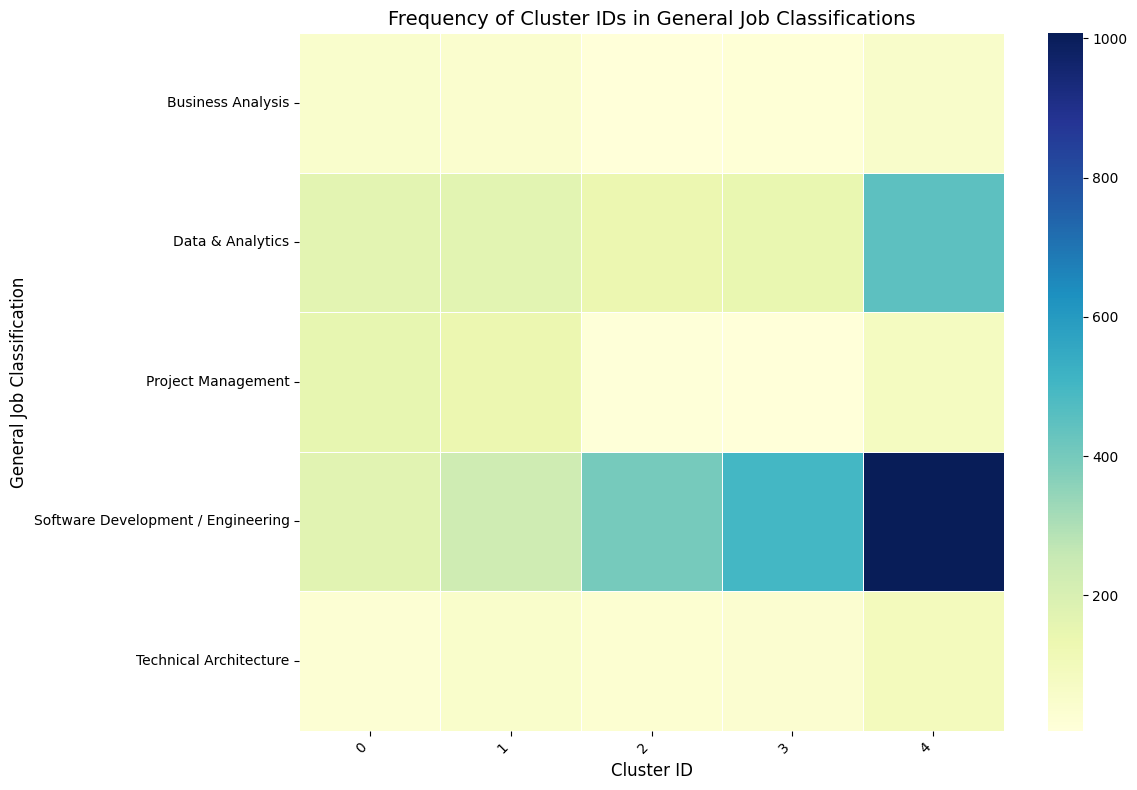

In [72]:
plot_cluster_heatmap(df_clustered_bert)

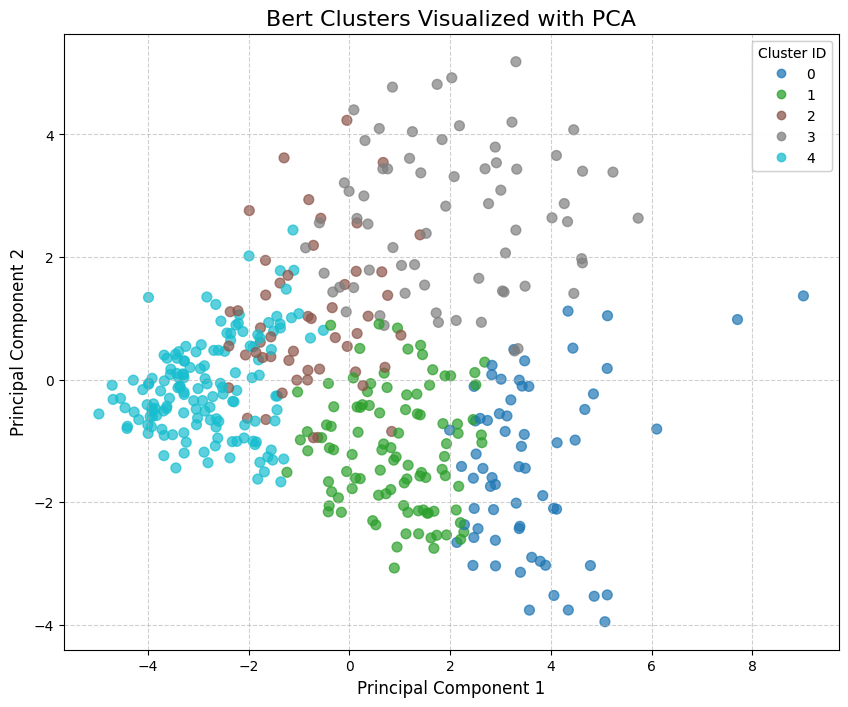

In [73]:
# Step 1: Dimensionality Reduction using PCA
pca = PCA(n_components=2, random_state=42)
bert_vectors_2d = pca.fit_transform(X_bert)

# Step 2: Create a DataFrame for easy plotting
pca_df = pd.DataFrame(bert_vectors_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels_bert  # Add cluster labels

# Step 3: Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=pca_df['Cluster'], 
    cmap='tab10',  # Use a colormap with distinct colors
    s=50, 
    alpha=0.7
)

# Add title and labels
plt.title('Bert Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="upper right")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# CREATING FEATURES AFTER CLUSTERING - one hot encoding

We will be using the resulting dataframe from clustering performed after tf idf word embedding.

Fristly, let's explore the created clusters

In [161]:
# count the most common skills in each cluster
def most_common_skills_per_cluster(df_clustered, skill_to_cluster_id, top_n=10):
    """
    Identifies the most common skills in each cluster.

    Args:
        df_clustered (pd.DataFrame): The DataFrame containing 'skills' and 'skill_cluster_ids'.
        skill_to_cluster_id (pd.Series): A mapping of skills to their cluster IDs.
        top_n (int): The number of top skills to return for each cluster.

    Returns:
        dict: A dictionary with cluster IDs as keys and lists of the most common skills as values.
    """
    cluster_skill_counter = {cluster_id: Counter() for cluster_id in skill_to_cluster_id.unique()}

    for _, row in df_clustered.iterrows():
        skills = row['skills']
        if not skills:
            continue
        for skill in skills:
            skill_lower = skill.lower()
            if skill_lower in skill_to_cluster_id:
                cluster_id = skill_to_cluster_id[skill_lower]
                cluster_skill_counter[cluster_id][skill_lower] += 1

    # Get the most common skills for each cluster
    most_common_skills = {
        cluster_id: [skill for skill, _ in counter.most_common(top_n)]
        for cluster_id, counter in cluster_skill_counter.items()
    }

    return most_common_skills

In [162]:
most_common_skills = most_common_skills_per_cluster(df_clustered_tfidf, skill_to_cluster_id, top_n=10)
for cluster_id, skills in most_common_skills.items():
    print(f"Cluster {cluster_id}: {', '.join(skills)}")
    print("-" * 50)

Cluster 2: python, javascript, c#, html, c++, java, react, typescript, aws, kubernetes
--------------------------------------------------
Cluster 5: sql, sql server, sql queries, pl/sql, microsoft sql server, ms sql server database, no-sql databases, azure sql, microsoft sql
--------------------------------------------------
Cluster 3: project management, construction management, database management, risk management, team management, change management, time management, data management, contract management, configuration management
--------------------------------------------------
Cluster 1: data analysis, data visualization, data modeling, data warehousing, data analytics, data governance, big data, data structures, data architecture, data engineering
--------------------------------------------------
Cluster 6: node.js, react.js, vue.js, next.js, express.js, js
--------------------------------------------------
Cluster 4: spring boot, spring, spring mvc, spring integration, spring se

In [163]:
# what clusters are repeated across general job classification
# Create binary features for each cluster
def create_cluster_features(cluster_ids, K):
    features = np.zeros(K)
    for cid in cluster_ids:
        if cid is not None and 0 <= cid < K:
            features[cid] = 1
    return features
cluster_features = df_clustered_tfidf['skill_cluster_ids'].apply(lambda ids: create_cluster_features(ids, K))


Generate Count Features: Use one-hot encoding or counting to create a feature for each cluster category. This is the final, most valuable feature set for your prediction model.

In [164]:
K=7
# # Explode the cluster IDs and count their frequency per job posting
# cluster_counts = df_clustered_tfidf.explode('skill_cluster_ids').groupby(level=0)['skill_cluster_ids'].value_counts()

# # Unstack the data to get one column per cluster, with the count as the value
# cluster_features = cluster_counts.unstack(fill_value=0)

# # Merge the new features back into your main DataFrame
# df_clustered_tfidf = df_clustered_tfidf.join(cluster_features)
cluster_counts = df_clustered_tfidf.explode('skill_cluster_ids').groupby(level=0)['skill_cluster_ids'].value_counts()
cluster_features = cluster_counts.unstack(fill_value=0)
cluster_features = cluster_features.reindex(df_clustered_tfidf.index, fill_value=0)   # <-- ensure full index
df_clustered_tfidf = df_clustered_tfidf.join(cluster_features)

In [165]:
# We are left with a dataframe where for each cluster id we count the number of occurences of a skill from that cluster in the job description - we can use thatb later for job success prediction
df_clustered_tfidf.head(10)

,title,description,general job classification,skills,formal_requirements,skill_cluster_ids,0,1,2,3,4,5,6,7
0,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",Software Development / Engineering,"[full-stack web development, javascript/typesc...",['3+ years of professional experience in softw...,"[2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2]",0,0,12,0,0,0,2,1
1,Computer Scientist,Are you passionate about developing cutting-ed...,Software Development / Engineering,"[software development, deep space communicatio...","[""Bachelor's degree in Computer Science or rel...",[2],0,0,1,0,0,0,0,0
2,Front end specialist,Regional law firm looking for a candidate with...,Software Development / Engineering,"[phone sales, customer service, interpersonal ...","['superior phone sales experience', 'passion f...","[0, 0, 2, 2]",2,0,2,0,0,0,0,0
3,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,Data & Analytics,"[data analysis, modeling, visualization, micro...","['MBA program with a focus in data analytics',...","[1, 2, 2]",0,1,2,0,0,0,0,0
4,Project Engineer,JOB DESCRIPTION:The Project Engineer assists t...,Project Management,"[construction/civil engineering, architecture,...","[""Bachelor's degree in Construction/Civil Engi...","[2, 3]",0,0,1,1,0,0,0,0
5,Data Architect,Request: Data ArchitectLocation: San Francisco...,Data & Analytics,"[aws, ec2, s3, lambda, glue, athena, kinesis, ...",['Contract'],"[2, 2, 2, 2, 1, 2, 5, 2, 2, 2, 2]",0,1,9,0,0,1,0,0
6,Java architect / Lead Java developer,Position: Java architect / Lead Java developer...,Technical Architecture,"[java, microservices, rest api, web services, ...","['Strong Experience on Java Platform', 'Hands ...","[2, 2, 2, 2, 2, 2, 6]",0,0,6,0,0,0,1,0
7,Enterprise Data & Analytics Infrastructure Man...,The Enterprise Data Infrastructure and Analyti...,Data & Analytics,"[data infrastructure, analytics, team manageme...","[""Bachelor's degree in Computer Science, Infor...","[2, 3, 2]",0,0,2,1,0,0,0,0
8,Senior Software Engineer,"StyleAI is the AI-powered, all-in-one unified ...",Software Development / Engineering,"[software development, innovative product laun...",['8+ years of experience in software developme...,"[2, 2, 2, 2, 2, 2]",0,0,6,0,0,0,0,0
9,Web Developer,We are looking to fill multiple Case Manger po...,Software Development / Engineering,"[case management, outreach services, food dist...","[""Bachelor's degree in Social Work, Counseling...",[2],0,0,1,0,0,0,0,0


# Understanding sentiment in job descriptions

### Because our job postings contain little emontional mark we will focus on the more nuanced aspects of the job posting.


We will use VADER Analysis  (Valence Aware Dictionary and sEntiment Reasoner)

In [ ]:
!pip install nltk

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliabarsow/nltk_data...


True

In [166]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df_clustered_tfidf['sentiment'] = df_clustered_tfidf['description'].apply(get_sentiment)

In [167]:
# scaling sentiment scores to introduce more variablity
df_clustered_tfidf['scaled_sentiment'] = -np.log10(1 - df_clustered_tfidf['sentiment'])

In [168]:
df_clustered_tfidf.head()

,title,description,general job classification,skills,formal_requirements,skill_cluster_ids,0,1,2,3,4,5,6,7,sentiment,scaled_sentiment
0,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",Software Development / Engineering,"[full-stack web development, javascript/typesc...",['3+ years of professional experience in softw...,"[2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2]",0,0,12,0,0,0,2,1,0.9989,2.958607
1,Computer Scientist,Are you passionate about developing cutting-ed...,Software Development / Engineering,"[software development, deep space communicatio...","[""Bachelor's degree in Computer Science or rel...",[2],0,0,1,0,0,0,0,0,0.9853,1.832683
2,Front end specialist,Regional law firm looking for a candidate with...,Software Development / Engineering,"[phone sales, customer service, interpersonal ...","['superior phone sales experience', 'passion f...","[0, 0, 2, 2]",2,0,2,0,0,0,0,0,0.9665,1.474955
3,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,Data & Analytics,"[data analysis, modeling, visualization, micro...","['MBA program with a focus in data analytics',...","[1, 2, 2]",0,1,2,0,0,0,0,0,0.9965,2.455932
4,Project Engineer,JOB DESCRIPTION:The Project Engineer assists t...,Project Management,"[construction/civil engineering, architecture,...","[""Bachelor's degree in Construction/Civil Engi...","[2, 3]",0,0,1,1,0,0,0,0,0.8779,0.913284


could alternatively use : from textblob import TextBlob for polarity scores

## Job Posting Success Prediction

In [169]:
# Columns from original dataset to keep for prediction
columns_to_keep = [
    'formatted_work_type',
    'views',
    'job_id',
    'description'
]

In [176]:
# columns to keep from clustered dataset
clustered_columns_to_keep = [
    'general job classification',
    'scaled_sentiment',
    'description',
    'job_id'
] + list(range(K))  # Add cluster count columns (0 to K-1)

linear regression
random forest regression
naive bayes
svm

In [172]:
data[columns_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   formatted_work_type  739 non-null    object 
 1   views                725 non-null    float64
 2   job_id               739 non-null    int64  
 3   description          739 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 23.2+ KB


In [208]:
# Merge df_clustered_tfidf with selected columns from original data
# TODO: ZMERGUJ PO JOB_ID i popraw prompt ollama
final_df = df_clustered_tfidf[clustered_columns_to_keep].merge(data[columns_to_keep], on='description', how='left')

In [209]:
# rename numeric cluster columns to have a prefix
final_df.rename(columns={i: f'cluster_{i}_count' for i in range(K)}, inplace=True)

In [210]:
final_df.head()

,general job classification,scaled_sentiment,description,cluster_0_count,cluster_1_count,cluster_2_count,cluster_3_count,cluster_4_count,cluster_5_count,cluster_6_count,formatted_work_type,views,job_id
0,Software Development / Engineering,2.958607,"Location: Remote\nCompany Overview:SkillFit, a...",0,0,12,0,0,0,2,Full-time,21.0,2234533717
1,Software Development / Engineering,1.832683,Are you passionate about developing cutting-ed...,0,0,1,0,0,0,0,Volunteer,NaN,2269442456
2,Software Development / Engineering,1.474955,Regional law firm looking for a candidate with...,2,0,2,0,0,0,0,Full-time,3.0,2314566469
3,Data & Analytics,2.455932,Summer Internshipadidas & Carhartt kids Divisi...,0,1,2,0,0,0,0,Temporary,5.0,2735151240
4,Project Management,0.913284,JOB DESCRIPTION:The Project Engineer assists t...,0,0,1,1,0,0,0,Full-time,4.0,3045980831


In [192]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2670 entries, 0 to 2772
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   general job classification  2670 non-null   object 
 1   scaled_sentiment            2670 non-null   float64
 2   description                 2670 non-null   object 
 3   cluster_0_count             2670 non-null   int64  
 4   cluster_1_count             2670 non-null   int64  
 5   cluster_2_count             2670 non-null   int64  
 6   cluster_3_count             2670 non-null   int64  
 7   cluster_4_count             2670 non-null   int64  
 8   cluster_5_count             2670 non-null   int64  
 9   cluster_6_count             2670 non-null   int64  
 10  formatted_work_type         2670 non-null   object 
 11  views                       2670 non-null   float64
 12  job_id                      2670 non-null   int64  
dtypes: float64(2), int64(8), object(3)
mem

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# drop rows where viewes is missing
final_df = final_df.dropna(subset=['views'])

cluster_cols = [f'cluster_{i}_count' for i in range(0, K)]

X = final_df[cluster_cols + ['scaled_sentiment', 'formatted_work_type', 'general job classification']]
y = final_df['views']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                  train_size=0.8)
print ('Size of training set = %d and test set = %d' % (y_train.size, y_test.size))

Size of training set = 2136 and test set = 534


In [212]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical features
col_dummny = ['formatted_work_type',  'general job classification']
# 1. Initialize the OneHotEncoder within a ColumnTransformer
# The 'handle_unknown="ignore"' tells the encoder to ignore (set to 0) 
# any categories in the test set that were not seen in the training set.
# 'drop='first'' mimics the behavior of drop_first=True in pd.get_dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         col_dummny)
    ],
    remainder='passthrough' # Keep other columns as they are
)

# 2. FIT the preprocessor ONLY on the training data
preprocessor.fit(X_train)

# 3. TRANSFORM both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for modeling, 
# ensuring consistent column names.
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with the new column names
X_train = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

In [213]:
# handle missing columns in test set
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 1502 to 2070
Data columns (total 17 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   onehot__formatted_work_type_Full-time                                  534 non-null    float64
 1   onehot__formatted_work_type_Internship                                 534 non-null    float64
 2   onehot__formatted_work_type_Other                                      534 non-null    float64
 3   onehot__formatted_work_type_Part-time                                  534 non-null    float64
 4   onehot__formatted_work_type_Temporary                                  534 non-null    float64
 5   onehot__general job classification_Data & Analytics                    534 non-null    float64
 6   onehot__general job classification_Project Management                  534 non-null    floa

In [214]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2136 entries, 1233 to 2706
Data columns (total 17 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   onehot__formatted_work_type_Full-time                                  2136 non-null   float64
 1   onehot__formatted_work_type_Internship                                 2136 non-null   float64
 2   onehot__formatted_work_type_Other                                      2136 non-null   float64
 3   onehot__formatted_work_type_Part-time                                  2136 non-null   float64
 4   onehot__formatted_work_type_Temporary                                  2136 non-null   float64
 5   onehot__general job classification_Data & Analytics                    2136 non-null   float64
 6   onehot__general job classification_Project Management                  2136 non-null   flo

In [215]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train) 

,priors,None
,var_smoothing,1e-09


In [216]:
training_predictions = model.predict(X_train)

In [217]:
test_predictions = model.predict(X_test)

In [221]:
from sklearn.metrics import accuracy_score, f1_score
train_accuracy = accuracy_score(y_train, training_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
train_f1 = f1_score(y_train, training_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# print results
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy:     {test_accuracy:.4f}")
print(f"Weighted F1 score for training:   {train_f1:.4f}")
print(f"Weighted F1 score for test:     {test_f1:.4f}")

Training accuracy: 0.0843
Test accuracy:     0.0169
Weighted F1 score for training:   0.0508
Weighted F1 score for test:     0.0025


In [226]:
# use xgboost model for prediction
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_training_predictions = xgb_model.predict(X_train)
xgb_test_predictions = xgb_model.predict(X_test)
xgb_train_mse = mean_squared_error(y_train, xgb_training_predictions)
xgb_test_mse = mean_squared_error(y_test, xgb_test_predictions)
print(f"XGBoost Training MSE: {xgb_train_mse:.4f}")
print(f"XGBoost Test MSE:     {xgb_test_mse:.4f}")

# print accuracy and f1 score for xgboost model
xgb_train_accuracy = accuracy_score(y_train, np.round(xgb_training_predictions))
xgb_test_accuracy = accuracy_score(y_test, np.round(xgb_test_predictions))
xgb_train_f1 = f1_score(y_train, np.round(xgb_training_predictions), average='weighted')
xgb_test_f1 = f1_score(y_test, np.round(xgb_test_predictions), average='weighted')
print(f"XGBoost Training accuracy: {xgb_train_accuracy:.4f}")
print(f"XGBoost Test accuracy:     {xgb_test_accuracy:.4f}")
print(f"XGBoost Weighted F1 score for training:   {xgb_train_f1:.4f}")
print(f"XGBoost Weighted F1 score for test:     {xgb_test_f1:.4f}")

XGBoost Training MSE: 3903.1048
XGBoost Test MSE:     14694.3509
XGBoost Training accuracy: 0.0360
XGBoost Test accuracy:     0.0150
XGBoost Weighted F1 score for training:   0.0380
XGBoost Weighted F1 score for test:     0.0144
